# Résolution de FBSDE avec l'algorithme 1 (contrôle basé sur X, Y)

Ce notebook implémente un algorithme de deep learning pour résoudre une équation différentielle stochastique avant-arrière (FBSDE) pleinement couplée, basé sur l'article de Ji et al. (2020).

In [1]:
print('try')

try


In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 5.9 MB/s eta 0:00:0000:0100:01


## Simulation FBSDE system Nash equilibrium, with $Z_t^\pm = 0$

Kappa = 2/3
KKappa = 1/3
#K = 3/8
K = 1
B = 1 / (2 * K * (1 - K * KKappa))
Beta = (1-2*K*KKappa)*B
Zeta = .5
Phi_I = Phi_M = 0
Alpha_I = Alpha_M = 0
Eta  = .5
T = 1.0
N = 50
#not used

Kappa = .8
KKappa = .1
K = 1
B = 1 / (2 * K * (1 - K * KKappa))
Beta = (1-2*K*KKappa)*B
Zeta = .5
Phi_I = Phi_M = 0
Alpha_I = Alpha_M = 0
Eta  = .5
T = 0.12
N = 20
SIG = 20

## New coeff

Kappa = 1.8
KKappa = .1
K = 4
B = 1 / (2 * K * (1 - K * KKappa))
Beta = (1-2*K*KKappa)*B
Zeta = .5
Phi_I = Phi_M = 0
Alpha_I = Alpha_M = 0
Eta  = .1
T = 0.01
N = 20
SIG = 50
d = (1/(2*Kappa)/(1+B/(2*Kappa)))      

def test_params():
    a = 6*T**2*+2*Beta**2-1/6
    b = 4*K**2*T**2 + 1/(2*Kappa**2)-1/6
    c = KKappa*K
    return a,b,c
print(test_params())

# New coeff with new proof (only use those)

In [485]:
Kappa = .00001
KKappa = .00001
K = 1
B = 1 / (2 * K * (1 - K * KKappa))
Beta = (1-2*K*KKappa)*B
Zeta = 1
Phi_I = Phi_M = 0
Alpha_I = Alpha_M = 0
Eta  =.1
T = .05
N = 100
SIG = 5
Kappa_a = 5
d = (1/(2*Kappa)/(1+B/(2*Kappa)))  
print(B*K,Beta*Zeta)

0.5000050000500005 0.49999499994999946


In [486]:
def condition():
    term1 = 8 * T**2 * d**2 + 4 * T**2 * B**2 * K**2 * d**2 + 4 * T**2 * d**2
    term2 = 8 * T**2 * d**2 * B**2 * K**2 + 4 * T**2 * B**2 * K**4 + 8 * T**2 * B**4 * K**4 * d**2 + 8 * T**2 * B**2 * K**2
    term3 = 16 * (Phi_I)**2 * T**2 + 128 * (T**2 * (Phi_I)**2 + (Alpha_I)**2)
    term4 = 16 * (Phi_M)**2 * T**2 + 128 * (T**2 * (Phi_M)**2 + (Alpha_M)**2)

    cond = max(term1, term2, term3, term4) < 1/4
    print(term1,term2,term3,term4)
    return(cond)
print(condition())

0.12998720093193988 0.032498250135741695 0.0 0.0
True


In [487]:
import torch
import torch.nn as nn

class ZNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super(ZNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, y_I, y_M, q_I, q_M):
        xy = torch.cat([y_I, y_M, q_I, q_M], dim=1)
        return self.net(xy)


In [488]:
def simulate_trajectory(Q0_I,Q0_M, Y0_I,Y0_M, Z_nets, 
                        b_QI,b_QM,b_YI,b_YM, T, N, dW_S,dW_A,eta = Eta,sigma_a = SIG):
    dt = T / N
    Q_I,Q_M, Y_I,Y_M, Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,alpha= [Q0_I],[Q0_M], [Y0_I],[Y0_M],[],[],[],[], [torch.zeros(1, 1).expand(Q0_I.shape[0], -1)]

    for i in range(N):
        t = i * dt
        q_I,q_M, y_I,y_M,Alpha = Q_I[-1],Q_M[-1], Y_I[-1],Y_M[-1],alpha[-1]
        
        z_IS = Z_nets[0][i](y_I,y_M,q_I,q_M)
        z_IA = Z_nets[1][i](y_I,y_M,q_I,q_M)
        z_MS = Z_nets[2][i](y_I,y_M,q_I,q_M)
        z_MA = Z_nets[3][i](y_I,y_M,q_I,q_M)
        
        Z_vals_IS.append(z_IS)
        Z_vals_IA.append(z_IA)
        Z_vals_MS.append(z_MS)
        Z_vals_MA.append(z_MA)
        
        dWt_S = dW_S[:, i, :]
        dWt_A = dW_A[:, i, :]
        
        q_I_next = q_I + b_QI(y_I,y_M) * dt 
        q_M_next = q_M + b_QM(y_I,y_M) * dt
        
        y_I_next = y_I + b_YI(q_I,Alpha) * dt + z_IS * dWt_S + z_IA * dWt_A
        y_M_next = y_M + b_YM(q_M,Alpha) * dt + z_MS * dWt_S + z_MA * dWt_A
        alpha_next = Alpha - eta * Alpha * dt + dWt_A*sigma_a
        
        alpha.append(alpha_next)
        Q_I.append(q_I_next)
        Q_M.append(q_M_next)
        Y_I.append(y_I_next)
        Y_M.append(y_M_next)
    
        
    return Q_I,Q_M,Y_I,Y_M,Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,alpha



In [489]:
def compute_loss(Y_I_T,Y_M_T,Q_I_T,Q_M_T,alpha_I=Alpha_I,alpha_M=Alpha_M):
    target_I = -2*alpha_I*Q_I_T
    target_M = - 2*alpha_M*Q_M_T
    return torch.mean((Y_I_T - target_I) ** 2 + (Y_M_T - target_M)**2)


In [490]:
def train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM,T, N, num_steps=100, batch_size=100):
    optimizer = torch.optim.Adam(
        [{'params': net.parameters()} for net_list in Z_nets for net in net_list] + [{'params': [Y0_I,Y0_M]}], 
        lr=1e-3
    )
    #dW_S_all = []
    #dW_A_all = []
    for step in range(num_steps):
        dW_S = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_A = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        
        #dW_S_all.append(dW_S)
        #dW_A_all.append(dW_A)


        Q_I_list,Q_M_list, Y_I_list,Y_M_list,_,_,_,_,_ = simulate_trajectory(
            Q0_I.expand(batch_size, -1), Q0_M.expand(batch_size,-1), Y0_I.expand(batch_size, -1), Y0_M.expand(batch_size, -1),
            Z_nets, b_QI,b_QM,b_YI,b_YM, T, N, dW_S,dW_A
        )
        loss = compute_loss(Y_I_list[-1],Y_M_list[-1], Q_I_list[-1],Q_M_list[-1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.5f}")

    return dW_S,dW_A #dW_S[0:1,:,:],dW_A[0:1,:,:]
            
        

In [491]:
# Fonctions dynamiques
def b_QI(y_I, y_M, beta=Beta, k=K, kappa=Kappa, zeta=Zeta,b=B,kappa_U=KKappa):
    c = -beta* zeta + y_I - b * k * y_M
    tilde_c = -beta * zeta - y_I + b * k * y_M

    left = torch.where(
        c > 0,
        (c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        (tilde_c / (2 * kappa) ) / (b / (2 * kappa) + 1),
        torch.zeros_like(tilde_c)
    )
    return left - right

def b_QM(y_I, y_M, beta=Beta, k=K, kappa=Kappa, zeta=Zeta,b=B,kappa_u = KKappa):
    c = -beta* zeta + y_I - b * k * y_M
    tilde_c = -beta  * zeta - y_I + b * k * y_M

    left = torch.where(
        c > 0,
        (c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        (tilde_c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(tilde_c)
    )
    return k*b*(left-right) + 2*k**2*b*y_M  - (left - right)

def b_YI(q_I, alpha, phi_I=Phi_I,kappa_a = Kappa_a):
    return 2 * phi_I * q_I - alpha*kappa_a

def b_YM(q_M, alpha, phi_M=Phi_M,kappa_a = Kappa_a):
    return 2 * phi_M * q_M - alpha*kappa_a


In [492]:
# Initialisation
dim_q_I = 1
dim_q_M = 1
dim_y_I = 1
dim_y_M = 1
input_dim = dim_q_I + dim_q_M + dim_y_I + dim_y_M


# Z_nets: 4 groupes de N réseaux chacun
Z_nets = [
    [ZNet(input_dim=input_dim) for _ in range(N)]  # Z_IS
    for _ in range(4)  # Z_IS, Z_IA, Z_MS, Z_MA
]

Q0_I = torch.zeros(1, dim_q_I)
Q0_M = torch.zeros(1, dim_q_M)
Y0_I = nn.Parameter(torch.ones(1, dim_y_I))
Y0_M = nn.Parameter(torch.ones(1, dim_y_M))

dW_S, dW_A = train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM, T, N)


Step 0, Loss: 2.07412


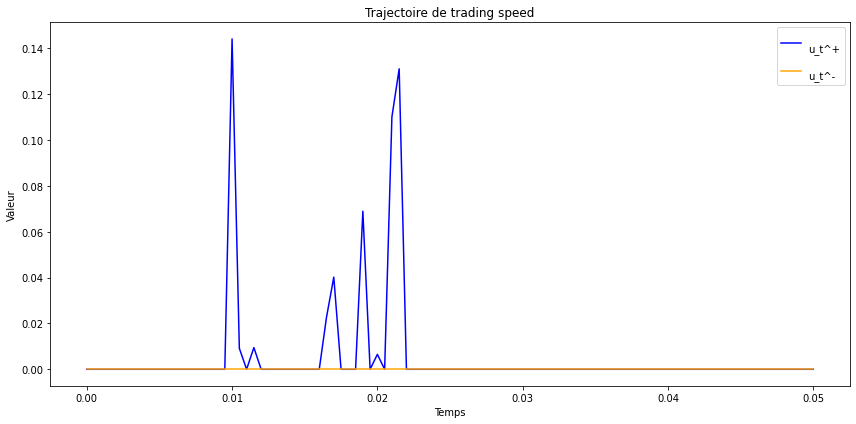

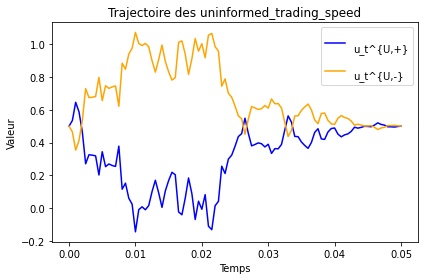

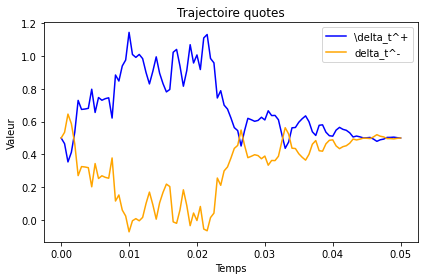

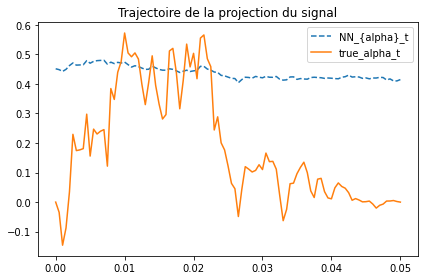

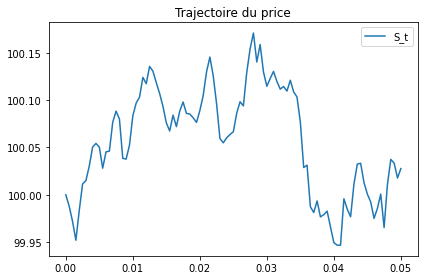

In [496]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher les courbes après l'entraînement
def plot_trajectory(Q_I, Q_M, Y_I, Y_M, alpha, T, N, batch_idx=0,batch_size=100):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][batch_idx].item() for t in range(N+1)]
    Q_M_vals = [Q_M[t][batch_idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][batch_idx].item() for t in range(N+1)]
    Y_M_vals = [Y_M[t][batch_idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][batch_idx].item() for t in range(N+1)]
    
    
    
    S_t = [100]
    for t in range(N):
        S_t.append(S_t[t] + Kappa_a*alpha_vals[t]*(T / N) + np.random.normal(0,1,1)*np.sqrt((T / N)))
    
    delta_plus = []
    delta_minus = []
    c=[]
    tilde_c =[]
    proj_alpha_compt = [Kappa_a*alpha_vals[t]*(1-np.exp(-(T-time_grid[t])))/Eta for t in range(N+1)]
    for t in range(N+1):
        #c.append(-B*(1-2*K*KKappa)*Zeta + Y_I_vals[t] - B*K*Y_M_vals[t])
        #tilde_c.append(-B*(1-2*K*KKappa)*Zeta- Y_I_vals[t] + B*K*Y_M_vals[t])
        
        #True params :
        c.append(-B*(1-2*K*KKappa)*Zeta + (1-B*K)*proj_alpha_compt[t])
        tilde_c.append(-B*(1-2*K*KKappa)*Zeta- (1-B*K)*proj_alpha_compt[t])

    
    nu_plus = []
    nu_minus = []
    nu_inf_plus = []
    nu_inf_minus = []
    for t in range(N+1):
        if c[t] <= 0:
            nu_plus.append(0)
        else:
            #nu_plus.append((c[t]/(2*Kappa))/((B/(2*Kappa)+1)))
            nu_plus.append(c[t]*1/(B+2*Kappa))
    
    for t in range(N+1):
        if tilde_c[t] <= 0:
            nu_minus.append(0)
        else:
            #nu_minus.append((tilde_c[t]/(2*Kappa))/((B/(2*Kappa)+1)) )  
            nu_minus.append(tilde_c[t]*1/(B+2*Kappa))
            
    for t in range(N+1):
        #delta_plus.append(Zeta-K*(B*nu_plus[t] + Beta*Zeta + B*K*Y_M_vals[t]))
        #delta_minus.append(Zeta-K*(B*nu_minus[t] + Beta*Zeta - B*K*Y_M_vals[t]))
        
        #true params
        nu_inf_plus.append(Zeta-K*(B*nu_plus[t] + Beta*Zeta + B*K*proj_alpha_compt[t]))
        nu_inf_minus.append(Zeta-K*(B*nu_minus[t] + Beta*Zeta - B*K*proj_alpha_compt[t]))
        
        delta_plus.append(B*nu_plus[t] + Beta*Zeta + B*K*proj_alpha_compt[t])
        delta_minus.append(B*nu_minus[t] + Beta*Zeta - B*K*proj_alpha_compt[t])


    proj_alpha = [ Y_I_vals[t] - B*K*Y_M_vals[t] for t in range(N+1)]
    proj_alpha_compt = [Kappa_a*(1-K*B)*alpha_vals[t]*(1-np.exp(-(T-time_grid[t])))/Eta for t in range(N+1)]
    
    # Tracer les courbes pour Q_I, Q_M, Y_I, Y_M
    plt.figure(figsize=(12, 6))

    # Trajectoire pour Q_I et Q_M
    plt.plot(time_grid, nu_plus, label="\nu_t^+", color='blue')
    plt.plot(time_grid, nu_minus, label="\nu_t^-", color='orange')
    plt.title("Trajectoire de trading speed")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    plt.plot(time_grid, nu_inf_plus, label="\nu_t^{U,+}", color='blue')
    plt.plot(time_grid, nu_inf_minus, label="\nu_t^{U,-}", color='orange')
    plt.title("Trajectoire des uninformed_trading_speed")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

        
    plt.plot(time_grid, delta_plus, label="\delta_t^+", color='blue')
    plt.plot(time_grid, delta_minus, label="delta_t^-", color='orange')
    plt.title("Trajectoire quotes")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    plt.plot(time_grid,proj_alpha,'--',label='NN_{alpha}_t')
    plt.plot(time_grid,proj_alpha_compt,label='true_alpha_t')
    plt.title("Trajectoire de la projection du signal")
    plt.legend()
    plt.tight_layout()
    plt.show()
        
        
    plt.plot(time_grid,S_t,label='S_t')
    plt.title("Trajectoire du price")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Fonction principale pour récupérer les valeurs et afficher les courbes
def plot_after_training(batch_size=100):
    # Récupérer la trajectoire simulée après l'entraînement
    Q_I, Q_M, Y_I, Y_M, _, _, _, _,alpha = simulate_trajectory(
        Q0_I.expand(batch_size, -1), Q0_M.expand(batch_size, -1), Y0_I.expand(batch_size, -1), Y0_M.expand(batch_size, -1), Z_nets, b_QI, b_QM, b_YI, b_YM, T, N,dW_S,dW_A)
    
    # Affichage des courbes pour le premier élément du batch
    plot_trajectory(Q_I, Q_M, Y_I, Y_M,alpha, T, N, batch_idx=20,batch_size=100)

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


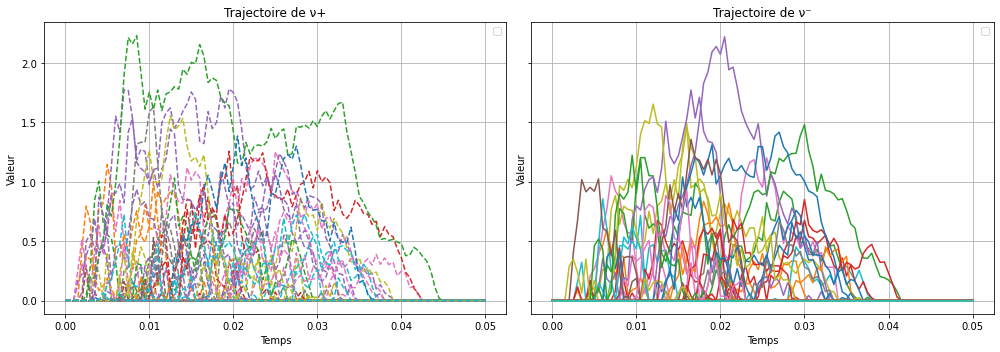

In [494]:
import matplotlib.pyplot as plt

# Fonction pour tracer nu⁺ et nu⁻ dans deux sous-graphes côte à côte
def plot_nu_trajectories(Q_I, Q_M, Y_I, Y_M, alpha, T, N, batch_indices):
    time_grid = [i * T / N for i in range(N+1)]
    nu_plus = []
    nu_minus = []

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

    for batch_idx in batch_indices:
        Q_I_vals = [Q_I[t][batch_idx].item() for t in range(N+1)]
        Q_M_vals = [Q_M[t][batch_idx].item() for t in range(N+1)]
        Y_I_vals = [Y_I[t][batch_idx].item() for t in range(N+1)]
        Y_M_vals = [Y_M[t][batch_idx].item() for t in range(N+1)]
        alpha_vals = [alpha[t][batch_idx].item() for t in range(N+1)]



        
        for t in range(N+1):
            #Estim params
            #c = -B*(1 - 2*K*KKappa)*Zeta + Y_I_vals[t] - B*K*Y_M_vals[t] 
            #tilde_c = -B*(1 - 2*K*KKappa)*Zeta - Y_I_vals[t] + B*K*Y_M_vals[t]
            
            #True parms:
            c = -B*(1-2*K*KKappa)*Zeta + Kappa_a*(1-B*K)*alpha_vals[t]*(1-np.exp(-(T-time_grid[t])))/Eta
            tilde_c = -B*(1-2*K*KKappa)*Zeta- Kappa_a*(1-B*K)*alpha_vals[t]*(1-np.exp(-(T-time_grid[t])))/Eta
            nu_plus.append((c/(2*Kappa))/(B/(2*Kappa)+1) if c > 0 else 0)
            nu_minus.append((tilde_c/(2*Kappa))/(B/(2*Kappa)+1) if tilde_c > 0 else 0)

        #nu_plus = [(ct/(2*Kappa))/(Beta/(2*Kappa)+1) if ct > 0 else 0 for ct in c]
        #nu_minus = [(tc/(2*Kappa))/(Beta/(2*Kappa)+1) if tc > 0 else 0 for tc in tilde_c]

        axes[0].plot(time_grid, nu_plus,'--')
        axes[1].plot(time_grid, nu_minus,'')
        nu_plus = []
        nu_minus = []

    axes[0].set_title("Trajectoire de ν+")
    axes[1].set_title("Trajectoire de ν⁻")

    for ax in axes:
        ax.set_xlabel("Temps")
        ax.set_ylabel("Valeur")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    
    for batch_idx in batch_indices:
        Q_I_vals = [Q_I[t][batch_idx].item() for t in range(N+1)]
        Q_M_vals = [Q_M[t][batch_idx].item() for t in range(N+1)]
        Y_I_vals = [Y_I[t][batch_idx].item() for t in range(N+1)]
        Y_M_vals = [Y_M[t][batch_idx].item() for t in range(N+1)]
        alpha_vals = [alpha[t][batch_idx].item() for t in range(N+1)]

# Fonction principale
def plot_after_training(batch_size=100, batch_indices=[0, 1, 2, 3, 4]):
    Q_I, Q_M, Y_I, Y_M, _, _, _, _, alpha = simulate_trajectory(
        Q0_I.expand(batch_size, -1),
        Q0_M.expand(batch_size, -1),
        Y0_I.expand(batch_size, -1),
        Y0_M.expand(batch_size, -1),
        Z_nets, b_QI, b_QM, b_YI, b_YM,
        T, N, dW_S, dW_A
    )

    plot_nu_trajectories(Q_I, Q_M, Y_I, Y_M, alpha, T, N, batch_indices)

# Appel de la fonction
plot_after_training(batch_size=100, batch_indices=[k for k in range(100)])


# Case with $Z_t^\pm \neq 0$ (good one)

In [115]:
Kappa = .1
KKappa = .1
K = 1
B = 1 / (2 * K * (1 - K * KKappa))
Beta = (1-2*K*KKappa)*B
Zeta = .5
Phi_I = Phi_M = 0
Alpha_I = Alpha_M = 0
Eta  = 1
T = 0.1
N = 50
SIG = 10
d = (1/(2*Kappa)/(1+B/(2*Kappa)))  
Eta_ZM = 0
Eta_ZP = 0
SIG_ZP = 0
SIG_ZM = 0

In [116]:
def condition():
    term1 = 8 * T**2 * d**2 + 4 * T**2 * B**2 * K**2 * d**2 + 4 * T**2 * d**2
    term2 = 8 * T**2 * d**2 * B**2 * K**2 + 4 * T**2 * B**2 * K**4 + 8 * T**2 * B**4 * K**4 * d**2 + 8 * T**2 * B**2 * K**2
    term3 = 16 * (Phi_I)**2 * T**2 + 128 * (T**2 * (Phi_I)**2 + (Alpha_I)**2)
    term4 = 16 * (Phi_M)**2 * T**2 + 128 * (T**2 * (Phi_M)**2 + (Alpha_M)**2)

    cond = max(term1, term2, term3, term4) < 1/4
    return(cond)
print(condition())

True


In [117]:
import torch
import torch.nn as nn

class ZNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super(ZNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, y_I, y_M, q_I, q_M,z_plus,z_minus,alpha):
        xy = torch.cat([y_I, y_M, q_I, q_M,z_plus,z_minus,alpha], dim=1)
        return self.net(xy)

In [118]:
def simulate_trajectory(Q0_I,Q0_M, Y0_I,Y0_M,Z_nets, 
                        b_QI,b_QM,b_YI,b_YM, T, N, dW_S,dW_A,dW_ZP,dW_ZM,eta = Eta,sigma_a = SIG,sigma_ZP = SIG_ZP, sigma_ZM = SIG_ZM
                       ,eta_ZP= Eta_ZP, eta_ZM = Eta_ZM):
    dt = T / N
    Q_I,Q_M, Y_I,Y_M, Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,Z_vals_I_plus,Z_vals_I_minus,Z_vals_M_plus,Z_vals_M_minus,alpha,Z_plus,Z_minus=[Q0_I],[Q0_M], [Y0_I],[Y0_M],[],[],[],[],[],[],[],[], [torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)]

    for i in range(N):
        t = i * dt
        q_I,q_M, y_I,y_M,Alpha,ZP,ZM = Q_I[-1],Q_M[-1], Y_I[-1],Y_M[-1],alpha[-1],Z_plus[-1],Z_minus[-1]

        z_IS = Z_nets[0][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_IA = Z_nets[1][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_MS = Z_nets[2][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_MA = Z_nets[3][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_I_plus = Z_nets[4][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_I_minus = Z_nets[5][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_M_plus = Z_nets[6][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_M_minus = Z_nets[7][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        
        Z_vals_IS.append(z_IS)
        Z_vals_IA.append(z_IA)
        Z_vals_MS.append(z_MS)
        Z_vals_MA.append(z_MA)
        Z_vals_I_plus.append(z_I_plus)
        Z_vals_I_minus.append(z_I_minus)
        Z_vals_M_plus.append(z_M_plus)
        Z_vals_M_minus.append(z_M_minus)
        
        dWt_S = dW_S[:, i, :]
        dWt_A = dW_A[:, i, :]
        dWt_ZP = dW_ZP[:,i,:]
        dWt_ZM = dW_ZM[:,i,:]
        
        q_I_next = q_I + b_QI(y_I,y_M, ZP,ZM) * dt 
        q_M_next = q_M + b_QM(y_I,y_M, ZP,ZM) * dt
        
        y_I_next = y_I + b_YI(q_I,Alpha) * dt + z_IS * dWt_S + z_IA * dWt_A
        y_M_next = y_M + b_YM(q_M,Alpha) * dt + z_MS * dWt_S + z_MA * dWt_A
        
        alpha_next = Alpha - eta * Alpha * dt + dWt_A*sigma_a
        z_plus_next = ZP - eta_ZP*ZP*dt + dWt_ZP*sigma_ZP
        z_minus_next = ZM - eta_ZM*ZM*dt + dWt_ZM*sigma_ZM
        
        Z_plus.append(z_plus_next)
        Z_minus.append(z_minus_next)
        alpha.append(alpha_next)
        Q_I.append(q_I_next)
        Q_M.append(q_M_next)
        Y_I.append(y_I_next)
        Y_M.append(y_M_next)
    
        
    return Q_I,Q_M,Y_I,Y_M,Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,Z_vals_I_plus,Z_vals_I_minus,Z_vals_M_plus,Z_vals_M_minus,alpha,Z_plus,Z_minus



In [119]:
def compute_loss(Y_I_T,Y_M_T,Q_I_T,Q_M_T,alpha_I=Alpha_I,alpha_M=Alpha_M):
    target_I = -2*alpha_I*Q_I_T
    target_M = - 2*alpha_M*Q_M_T
    return torch.mean((Y_I_T - target_I) ** 2 + (Y_M_T - target_M)**2)

In [120]:
def train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM,T, N, num_steps=1_000, batch_size=100):
    optimizer = torch.optim.Adam(
        [{'params': net.parameters()} for net_list in Z_nets for net in net_list] + [{'params': [Y0_I,Y0_M]}], 
        lr=1e-3
    )
    #dW_S_all = []
    #dW_A_all = []
    for step in range(num_steps):
        dW_S = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_A = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_ZP = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_ZM = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        
        #dW_S_all.append(dW_S)
        #dW_A_all.append(dW_A)


        Q_I_list,Q_M_list, Y_I_list,Y_M_list,_,_,_,_,_,_,_,_,_,_,_ = simulate_trajectory(
            Q0_I.expand(batch_size, -1), Q0_M.expand(batch_size,-1), Y0_I.expand(batch_size, -1), Y0_M.expand(batch_size, -1),Z_nets, b_QI,b_QM,b_YI,b_YM, T, N,  dW_S,dW_A,dW_ZP,dW_ZM)
        loss = compute_loss(Y_I_list[-1],Y_M_list[-1], Q_I_list[-1],Q_M_list[-1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.5f}")

    return dW_S,dW_A,dW_ZP,dW_ZM #dW_S[0:1,:,:],dW_A[0:1,:,:]

In [121]:
# Fonctions dynamiques
def b_QI(y_I, y_M, z_plus,z_minus, beta=Beta, k=K, kappa=Kappa, zeta=Zeta,b=B,kappa_U=KKappa):
    c = -beta* (zeta+z_plus) + y_I - b * k * y_M
    tilde_c = -beta * (zeta+z_minus) - y_I + b * k * y_M

    left = torch.where(
        c > 0,
        (c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        (tilde_c / (2 * kappa) ) / (b / (2 * kappa) + 1),
        torch.zeros_like(tilde_c)
    )
    return left - right

def b_QM(y_I, y_M, z_plus,z_minus, beta=Beta, k=K, kappa=Kappa, zeta=Zeta,b=B,kappa_u = KKappa):
    c = -beta* (zeta+z_plus) + y_I - b * k * y_M
    tilde_c = -beta  * (zeta+z_minus) - y_I + b * k * y_M

    left = torch.where(
        c > 0,
        (c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        (tilde_c / (2 * kappa)) / (b / (2 * kappa) + 1),
        torch.zeros_like(tilde_c)
    )
    return k*b*(left-right) + 2*k**2*b*y_M  - (left - right) + b*(z_minus-z_plus + k*beta*(z_plus-z_minus))

def b_YI(q_I, alpha, phi_I=Phi_I):
    return 2 * phi_I * q_I - alpha

def b_YM(q_M, alpha, phi_M=Phi_M):
    return 2 * phi_M * q_M - alpha


In [122]:
# Initialisation
dim_q_I = 1
dim_q_M = 1
dim_y_I = 1
dim_y_M = 1
dim_z_plus = 1
dim_z_minus = 1
dim_alpha = 1
input_dim = dim_q_I + dim_q_M + dim_y_I + dim_y_M + dim_z_plus + dim_z_minus + dim_alpha


# Z_nets: 4 groupes de N réseaux chacun
Z_nets = [
    [ZNet(input_dim=input_dim) for _ in range(N)]  # Z_IS
    for _ in range(8)  # Z_IS, Z_IA, Z_MS, Z_MA
]

Q0_I = torch.zeros(1, dim_q_I)
Q0_M = torch.zeros(1, dim_q_M)
Y0_I = nn.Parameter(torch.full((1, dim_q_I), 1.))
Y0_M = nn.Parameter(torch.full((1, dim_q_M), 1.))

dW_S, dW_A,dW_ZP,dW_ZM = train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM, T, N)


Step 0, Loss: 2.02387
Step 100, Loss: 1.59602
Step 200, Loss: 1.35069
Step 300, Loss: 1.05698
Step 400, Loss: 0.82723
Step 500, Loss: 0.61261
Step 600, Loss: 0.48322
Step 700, Loss: 0.35385
Step 800, Loss: 0.25928
Step 900, Loss: 0.19124


In [123]:
sample = 100

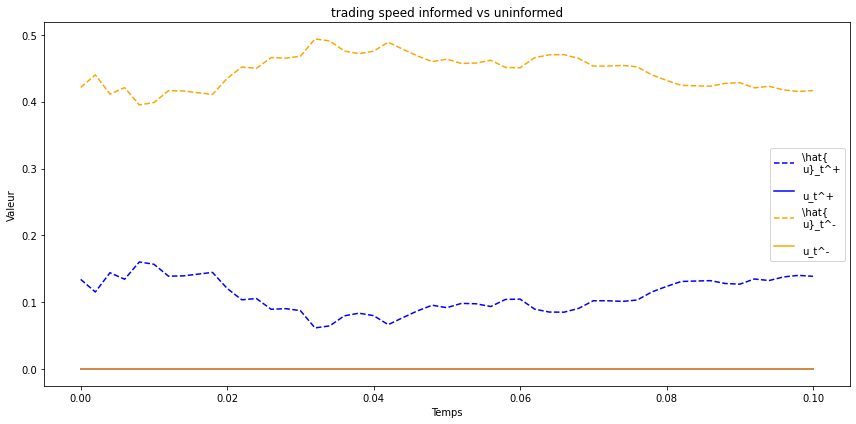

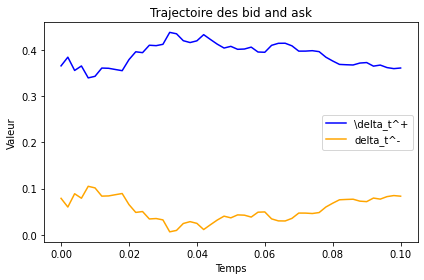

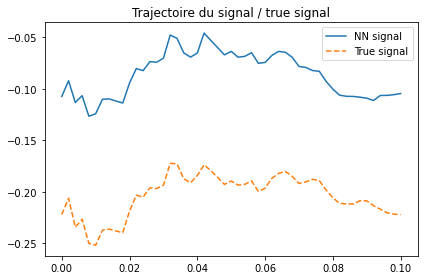

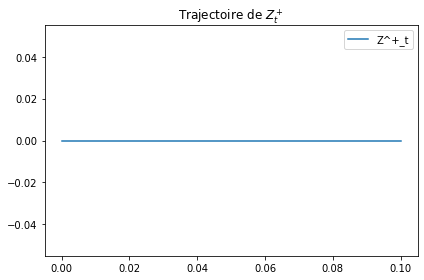

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher les courbes après l'entraînement
def plot_trajectory(Q_I, Q_M, Y_I, Y_M, alpha, Z_plus,Z_minus, T, N, sample_idx=0,sample_size=sample):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][sample_idx].item() for t in range(N+1)]
    Q_M_vals = [Q_M[t][sample_idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][sample_idx].item() for t in range(N+1)]
    Y_M_vals = [Y_M[t][sample_idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][sample_idx].item() for t in range(N+1)]
    Z_plus_vals = [Z_plus[t][sample_idx].item() for t in range(N+1)]
    Z_minus_vals = [Z_minus[t][sample_idx].item() for t in range(N+1)]

    
    
    delta_plus = []
    delta_minus = []
    c=[]
    tilde_c =[]
    for t in range(N+1):
        c.append(-B*(1-2*K*KKappa)*(Zeta+Z_plus_vals[t]) + Y_I_vals[t] - B*K*Y_M_vals[t])
        tilde_c.append(-B*(1-2*K*KKappa)*(Zeta+Z_minus_vals[t])- Y_I_vals[t] + B*K*Y_M_vals[t])

    
    nu_plus = []
    nu_minus = []
    for t in range(N+1):
        if c[t] <= 0:
            nu_plus.append(0)
        else:
            nu_plus.append((c[t]/(2*Kappa))/((B/(2*Kappa)+1)))
    
    for t in range(N+1):
        if tilde_c[t] <= 0:
            nu_minus.append(0)
        else:
            nu_minus.append((tilde_c[t]/(2*Kappa))/((B/(2*Kappa)+1)) )  
            
    for t in range(N+1):
        delta_plus.append(B*nu_plus[t] + Beta*(Zeta+Z_plus_vals[t]) + B*K*Y_M_vals[t])
        delta_minus.append(B*nu_minus[t] + Beta*(Zeta+Z_minus_vals[t]) - B*K*Y_M_vals[t])

    
    proj_alpha_compt = [-B*(1-2*K*KKappa)*(Zeta+Z_plus_vals[t]) +(1-K*B)*alpha_vals[t]*(1-np.exp(-(T-time_grid[t])))/Eta for t in range(N+1)]
    # Tracer les courbes pour Q_I, Q_M, Y_I, Y_M
    plt.figure(figsize=(12, 6))

    # Trajectoire pour Q_I et Q_M
    plt.plot(time_grid,[Zeta - K*delta_plus[t]+Z_plus_vals[t] for t in range(len(delta_plus))],'--',label='\hat{\nu}_t^+', color='blue')
    plt.plot(time_grid, nu_plus, label="\nu_t^+", color='blue')
    plt.plot(time_grid,[Zeta - K*delta_minus[t]+Z_minus_vals[t] for t in range(len(delta_plus))],'--',label='\hat{\nu}_t^-', color='orange')
    plt.plot(time_grid, nu_minus, label="\nu_t^-", color='orange')
    plt.title("trading speed informed vs uninformed")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    plt.plot(time_grid, delta_plus, label="\delta_t^+", color='blue')
    plt.plot(time_grid, delta_minus, label="delta_t^-", color='orange')
    plt.title("Trajectoire des bid and ask")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    plt.plot(time_grid,c,label='NN signal')
    plt.plot(time_grid,proj_alpha_compt,'--',label='True signal')
    plt.title("Trajectoire du signal / true signal")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid,Z_plus_vals,label="Z^+_t")
    plt.title('Trajectoire de $Z_t^+$')
    plt.legend()
    plt.tight_layout()
    plt.show()

        
# Fonction principale pour récupérer les valeurs et afficher les courbes
def plot_after_training(sample_size=sample):
    dW_S = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZP = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZM = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    # Récupérer la trajectoire simulée après l'entraînement
    Q_I,Q_M, Y_I,Y_M,_,_,_,_,_,_,_,_,alpha,Z_plus,Z_minus = simulate_trajectory(
            Q0_I.expand(sample_size, -1), Q0_M.expand(sample_size,-1), Y0_I.expand(sample_size, -1), Y0_M.expand(sample_size, -1),Z_nets, b_QI,b_QM,b_YI,b_YM, T, N,  dW_S,dW_A,dW_ZP,dW_ZM)
    # Affichage des courbes pour le premier élément du batch
    plot_trajectory(Q_I, Q_M, Y_I, Y_M,alpha,Z_plus,Z_minus, T, N, sample_idx=80,sample_size=sample)

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


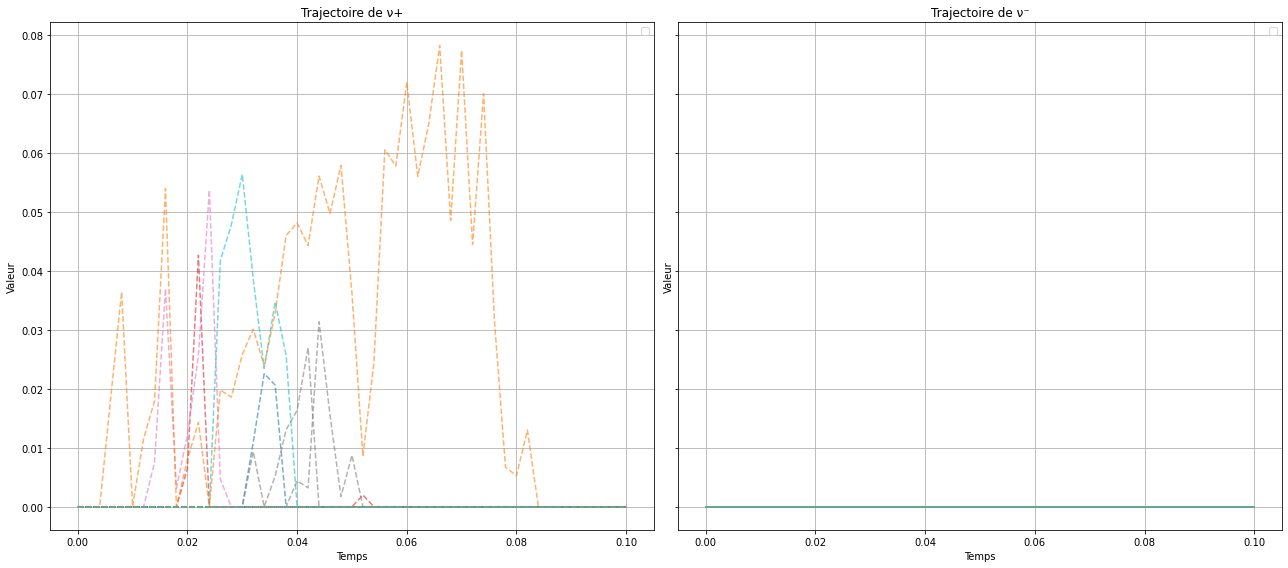

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher les courbes après l'entraînement

def plot_trajectory(Q_I, Q_M, Y_I, Y_M, alpha, Z_plus, Z_minus, T, N, batch_indices=[0, 1, 2, 3, 4]):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

    for batch_idx in batch_indices:
        # Récupération des valeurs pour chaque élément du batch
        Q_I_vals = [Q_I[t][batch_idx].item() for t in range(N+1)]
        Q_M_vals = [Q_M[t][batch_idx].item() for t in range(N+1)]
        Y_I_vals = [Y_I[t][batch_idx].item() for t in range(N+1)]
        Y_M_vals = [Y_M[t][batch_idx].item() for t in range(N+1)]
        alpha_vals = [alpha[t][batch_idx].item() for t in range(N+1)]
        Z_plus_vals = [Z_plus[t][batch_idx].item() for t in range(N+1)]
        Z_minus_vals = [Z_minus[t][batch_idx].item() for t in range(N+1)]

        # Calcul de c et tilde_c pour chaque point temporel
        c = []
        tilde_c = []
        nu_plus = []
        nu_minus = []
        for t in range(N+1):
            c_t = -B*(1-2*K*KKappa)*(Zeta+Z_plus_vals[t]) + Y_I_vals[t] - B*K*Y_M_vals[t]
            tilde_c_t = -B*(1-2*K*KKappa)*(Zeta+Z_minus_vals[t]) - Y_I_vals[t] + B*K*Y_M_vals[t]
            c.append(c_t)
            tilde_c.append(tilde_c_t)
            nu_plus.append((c_t/(2*Kappa))/(B/(2*Kappa)+1) if c_t > 0 else 0)
            nu_minus.append((tilde_c_t/(2*Kappa))/(B/(2*Kappa)+1) if tilde_c_t > 0 else 0)

        # Traçage des trajectoires pour ce batch
        axes[0].plot(time_grid, nu_plus, '--', alpha=0.6)
        axes[1].plot(time_grid, nu_minus, alpha=0.6)

    # Ajustement des graphes
    axes[0].set_title("Trajectoire de ν+")
    axes[1].set_title("Trajectoire de ν⁻")
    for ax in axes:
        ax.set_xlabel("Temps")
        ax.set_ylabel("Valeur")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_after_training(batch_size=100):
    # Récupérer les trajectoires simulées après l'entraînement
    Q_I, Q_M, Y_I, Y_M, _, _, _, _, _, _, _, _, alpha, Z_plus, Z_minus = simulate_trajectory(
        Q0_I.expand(batch_size, -1), Q0_M.expand(batch_size, -1),
        Y0_I.expand(batch_size, -1), Y0_M.expand(batch_size, -1),
        Z_nets, b_QI, b_QM, b_YI, b_YM, T, N, dW_S, dW_A, dW_ZP, dW_ZM
    )
    # Affichage des courbes pour tous les éléments du batch
    plot_trajectory(Q_I, Q_M, Y_I, Y_M, alpha, Z_plus, Z_minus, T, N, batch_indices=range(batch_size))

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training(batch_size=100)


# Fixed point in simplified model $\phi^{I,M} = \alpha^{I,M} = 0$

In [126]:
import numpy as np
import matplotlib.pyplot as plt
N = 100
T = 10
Kappa_I = .6
Kappa_U = .1
K = 1
Beta = 1 / (2 * K * (1 - K * Kappa_U))
Zeta = 1
Z_max_plus = Z_max_minus = .5
Z_bar_pm = .1
eta_a =1
sigma_a = 1
eta_ZP = 1
sigma_ZP = .5
eta_ZM = 1
sigma_ZM =.5
dt = T/N
kappa_a = 1
sigma_S = 1
S_0 = 100
nu_plus = np.zeros((N))
delta_plus = np.zeros((N))
nu_minus = np.zeros((N))
delta_minus = np.zeros((N))
time = np.linspace(0,T,N)
print(Beta<1)
print(1-K*Beta)
print(Beta)
print(1/(2*Kappa_I)<1)
print(Beta*(1-2*K*Kappa_U))

True
0.4444444444444444
0.5555555555555556
True
0.4444444444444445


In [127]:
seed = 1357
import random
random.seed(seed)
np.random.seed(seed)
alpha = np.zeros(N)
for t in range(N-1):
    alpha[t+1] = alpha[t] -eta_a *alpha[t]*dt + sigma_a * np.random.normal(0,1,1)*np.sqrt(dt)

Z_t_plus = np.zeros(N)
Z_t_minus = np.zeros(N)
for t in range(N-1):
    Z_t_plus[t+1] = Z_t_plus[t] -eta_ZP *Z_t_plus[t]*dt + sigma_ZP * np.random.normal(0,1,1)*np.sqrt(dt)
    Z_t_plus[t+1] = max(-Z_bar_pm,min(Z_bar_pm,Z_t_plus[t+1]))
    Z_t_minus[t+1] = Z_t_minus[t] -eta_ZM *Z_t_minus[t]*dt + sigma_ZM * np.random.normal(0,1,1)*np.sqrt(dt)
    Z_t_minus[t+1] = max(-Z_bar_pm,min(Z_bar_pm,Z_t_minus[t+1]))

esp_alpha = np.zeros(N)
for t in range(N):
    esp_alpha[t] =  alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a
    
n_iter = 1_000
for n in  range(n_iter):
    NP = nu_plus.copy()
    NM = nu_minus.copy()
    for t in range(N):
        nu_plus[t] = 1/(2*Kappa_I) * max((-delta_plus[t] + alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a),0)
        nu_minus[t] = 1/(2*Kappa_I) * max((-delta_minus[t] - alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a),0)
        #real:
        #delta_plus[t] = (min((Zeta-Z_max_plus)/K,Beta*(NP[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_plus[t]) + K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))
        #delta_minus[t] = (min((Zeta-Z_max_minus)/K,Beta*(NM[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_minus[t]) - K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))
        
        #without constraint
        #delta_plus[t] =Beta*(NP[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_plus[t]) + K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)
        #delta_minus[t] = Beta*(NM[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_minus[t]) - K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)
        
        #average constraint
        delta_plus[t] = (min((Zeta)/K,Beta*(NP[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_plus[t]) + K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))
        delta_minus[t] = (min((Zeta)/K,Beta*(NM[t] + (1-2*K*Kappa_U)*(Zeta+Z_t_minus[t]) - K*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))

        

nu_U_plus = []
nu_U_minus=[]
for t in range(N):
    nu_U_plus.append(Zeta-K*delta_plus[t]+Z_t_plus[t])
    nu_U_minus.append(Zeta-K*delta_minus[t] + Z_t_minus[t])
        
S_t = np.zeros(N)
S_t_plus = np.zeros(N)
S_t_minus = np.zeros(N)

S_t[0] = S_0
S_t_plus[0] = S_t[0] + delta_plus[0]
S_t_minus[0] = S_t[0] - delta_minus[0]
for t in range(N-1):
    S_t[t+1] = S_t[t] +kappa_a *alpha[t]*dt + sigma_S * np.random.normal(0,1,1)*np.sqrt(dt)
    S_t_plus[t+1] = S_t[t+1] + delta_plus[t+1]
    S_t_minus[t+1] = S_t[t+1] -delta_minus[t+1]
    
    

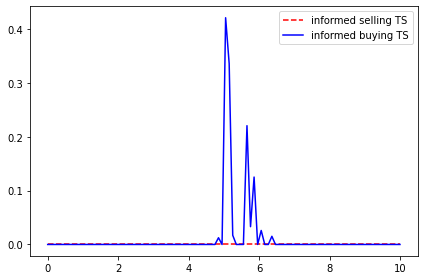

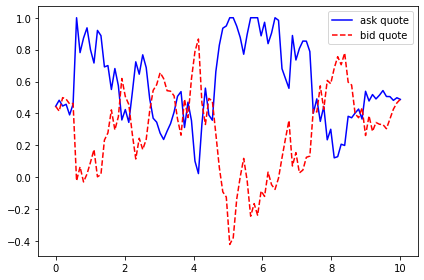

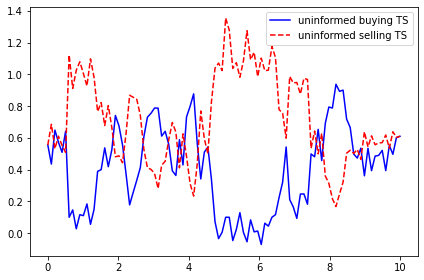

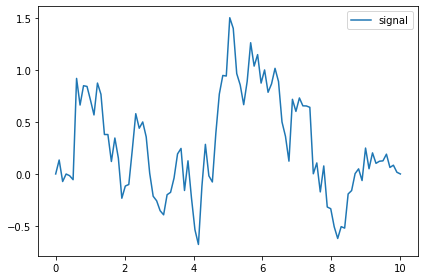

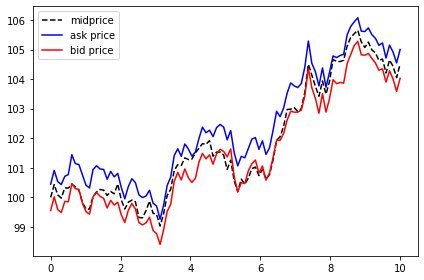

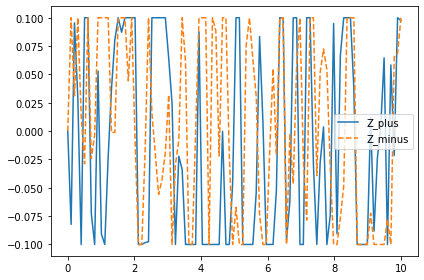

In [128]:
#plt.plot(time,np.array(nu_plus)-np.array(nu_minus),label='informed TS',color="blue")
plt.plot(time,nu_minus,'--', label='informed selling TS',color='red')
plt.plot(time,nu_plus, label='informed buying TS',color='blue')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(time,delta_plus,label='ask quote',color="blue")
plt.plot(time,delta_minus,'--', label='bid quote',color="red")
plt.legend()
plt.tight_layout()
plt.show()

#plt.plot(time,np.array(nu_U_plus)-np.array(nu_U_minus),label='uninformed TS',color="blue")
plt.plot(time,nu_U_plus, label='uninformed buying TS',color="blue")
plt.plot(time,nu_U_minus,'--', label='uninformed selling TS',color="red")
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(time,esp_alpha,label='signal')
plt.legend()
plt.tight_layout()
plt.show()
    

plt.plot(time,S_t,'--',label='midprice',color="black")
plt.plot(time,S_t_plus,label='ask price',color="blue")
plt.plot(time,S_t_minus,label='bid price',color="red")
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(time,Z_t_plus,label='Z_plus')
plt.plot(time,Z_t_minus,'--', label='Z_minus')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
Q_I_plus = [np.array(nu_plus)]
Q_I_minus = [np.array(nu_minus)]

In [125]:
Q_M_plus = [np.array(delta_plus)]
Q_M_minus = [np.array(delta_minus)]

In [131]:
Q_I_plus.append(np.array(nu_plus))
Q_I_minus.append(np.array(nu_minus))

In [132]:
Q_M_plus.append(np.array(delta_plus))
Q_M_minus.append(np.array(delta_minus))

In [133]:
print(Q_I_plus[0]- Q_I_plus[1])
print(Q_I_minus[0]- Q_I_minus[1])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02148507 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.06526081
 0.10126582 0.0886384  0.         0.         0.03182894 0.08825229
 0.03811117 0.09935004 0.         0.03788634 0.         0.07039385
 0.10062499 0.07273653 0.07104719 0.03612198 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

## When $Z_t$ is smaller, the informed trader trades less

# General case: $\alpha^{I,M} \neq 0$ and $\phi^{I,M} \neq 0$ without constraints on $\delta_t$